In [21]:
from matplotlib import pyplot as plt
import numpy as np
from numba import njit, prange, jit

newparams = {'figure.figsize': (12, 6), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings


warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [22]:
@njit()
def wall_potential_function_numpy(particle, K, L):
    potential = 0
    if particle[0] > L:
        potential += K/2 * (particle[0]-L)**2
    elif particle[0] < 0:
        potential += K/2 * particle[0]**2
    
    if particle[1] > L:
        potential += K/2 * (particle[1]-L)**2
    elif particle[1] < 0:
        potential += K/2 * particle[1]**2
    
    return potential

@njit()
def calculate_pressure_function_numpy(particle_array, K, L):
    total_pressure = 0
    for p in particle_array:
        if p[0] > L:
            total_pressure += K*abs(p[0]-L)
        elif p[0] < 0:
            total_pressure += K*abs(p[0])

        if p[1] > L:
            total_pressure += K*abs(p[1]-L)
        elif p[1] < 0:
            total_pressure += K*abs(p[1])

    return total_pressure/(4*L)

@njit()
def hardcore_repulsion_potential_function(p1, p2, a, U):
    if np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) < a:
        return U
    return 0.0 

@njit()
def lennard_jones_potential_function(p1, p2, a, epsilon):
    rij = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return epsilon*((a/rij)**12 - 2*(a/rij)**6)

@jit()
def jitted_Montecarlo(out, particle_array, wall_potential_function, interaction_potential_function, iterations, beta, b = 0.5):
    for i in range(iterations):
        index = np.random.randint(0, particle_array.shape[0])
        dx = (np.random.random() - 0.5)*b
        dy = (np.random.random() - 0.5)*b
        p_next = np.array(out[i, index]) + np.array([dx, dy])
        delta_wall_potential = wall_potential_function(p_next) - wall_potential_function(out[i, index]) 
        delta_interaction_potential = 0
        
        interaction_potential = 0
        old_interaction_potential = 0
        
        if interaction_potential_function != None:
            for j in range(particle_array.shape[0]):
                if j != index:
                    interaction_potential += interaction_potential_function(p_next, out[i, j])
                    old_interaction_potential += interaction_potential_function(out[i, index], out[i, j])
        delta_interaction_potential = interaction_potential - old_interaction_potential

        dE = delta_interaction_potential + delta_wall_potential
        
        out[i+1] = out[i]
        if dE <= 0:
            out[i+1, index] = p_next
            
        else:
            probability = np.random.random()  
            if probability < np.exp(-beta*dE):
                out[i+1, index] = p_next
    return out
    

In [19]:
def MonteCarlo_metropolis2D_numpy(particle_array, wall_potential_function, interaction_potential_function, iterations, beta, b = 0.5):
    out = np.zeros((iterations+1, *particle_array.shape))
    out[0] = particle_array

    return jitted_Montecarlo(out, particle_array, wall_potential_function, interaction_potential_function, iterations, beta, b)
#     out[0] = particle_array
#     for i in range(iterations):
#         index = np.random.randint(0, particle_array.shape[0])
#         dx = (np.random.random() - 0.5)*b
#         dy = (np.random.random() - 0.5)*b
#         p_next = np.array(out[i, index]) + np.array([dx, dy])
#         delta_wall_potential = wall_potential_function(p_next) - wall_potential_function(out[i, index]) 
#         delta_interaction_potential = 0
        
#         interaction_potential = 0
#         old_interaction_potential = 0
        
#         if interaction_potential_function != None:
#             for j in range(particle_array.shape[0]):
#                 if j != index:
#                     interaction_potential += interaction_potential_function(p_next, out[i, j])
#                     old_interaction_potential += interaction_potential_function(out[i, index], out[i, j])
#         delta_interaction_potential = interaction_potential - old_interaction_potential

#         dE = delta_interaction_potential + delta_wall_potential
        
#         out[i+1] = out[i]
#         if dE <= 0:
#             out[i+1, index] = p_next
            
#         else:
#             probability = np.random.random()  
#             if probability < np.exp(-beta*dE):
#                 out[i+1, index] = p_next
#     return out
    


## Taske a)

In [23]:
N = 200
L = 10
K = 1
beta =(1e-23 * 300)**(-1)
steps = 10000
a = 1
b= 0.5
particle_list = np.zeros((N, 2))
for i in range(N):
    particle_list[i] = np.array([np.random.random()*L, np.random.random()*L])

states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), lambda p1, p2 : 0, steps, beta, b)
# x_values, y_values = states[-1].get_points_lists()

# # lambda p1, p2 : hardcore_repulsion_potential_function(p1, p2, a, 1000/beta)

# fig, ax = plt.subplots()
# rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
# ax.plot(x_values, y_values, "o")
# ax.add_patch(rect)
# plt.show()

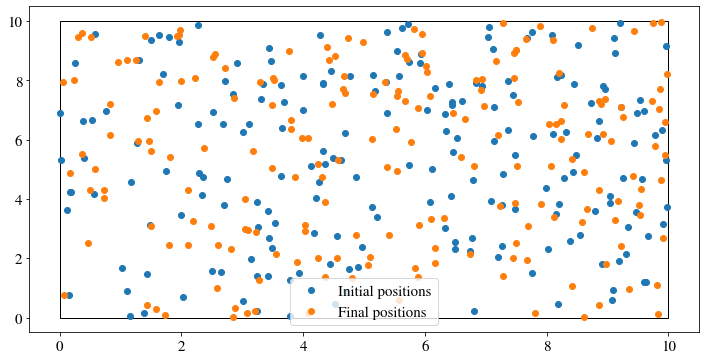

In [24]:
fig, ax = plt.subplots()
ax.plot(states[0, :, 0], states[0, :, 1], "o", label="Initial positions")
ax.plot(states[-1, :, 0], states[-1, :, 1], "o", label="Final positions")
rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
ax.add_patch(rect)
ax.legend()
plt.show()

The figure above shows that there is sufficient movement for the particles from the initial position to the final position.

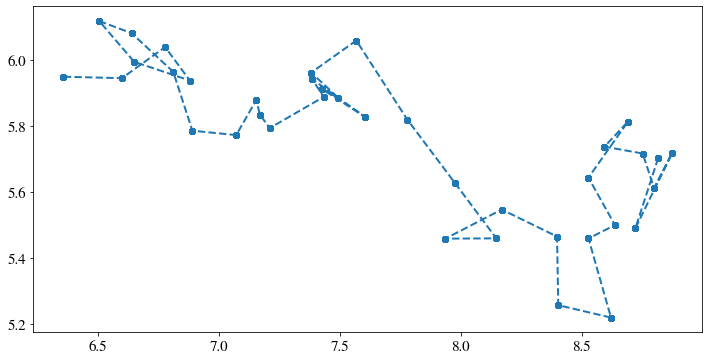

In [8]:
j = np.random.randint(0, states.shape[1])
p1_x_values = states[:, j, 0] 
p1_y_values = states[:, j, 1] 

# x_values, y_values = states[0].get_points_lists()

# plt.plot(p1_y_values)
# fig, ax = plt.subplots()
plt.plot(p1_x_values, p1_y_values, "--o")
plt.show()
# states[-1].plot_particles()

The plot above shows the path of a random particle during the simulation.

In [25]:
lengths = np.linspace(50, 200, 20)
N = 200
kB = 1.38e-23
T = 100
beta =(kB * T)**(-1)
K = 200/beta
steps = 100000
a = 1
b= 0.5

print("^"*len(lengths))
avg_pressure_list = []
for L in lengths:
    particle_list = np.zeros((N, 2))
    for i in range(N):
        particle_list[i] = np.array([np.random.random()*L, np.random.random()*L])
    print("*", end="")
    states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), None, steps, beta, b)
    pressure_list = np.array([calculate_pressure_function_numpy(states[i], K, L) for i in range(0, states.shape[0], 100)])
    avg_pressure = np.average(pressure_list)
    avg_pressure_list.append(avg_pressure)



^^^^^^^^^^^^^^^^^^^^
********************

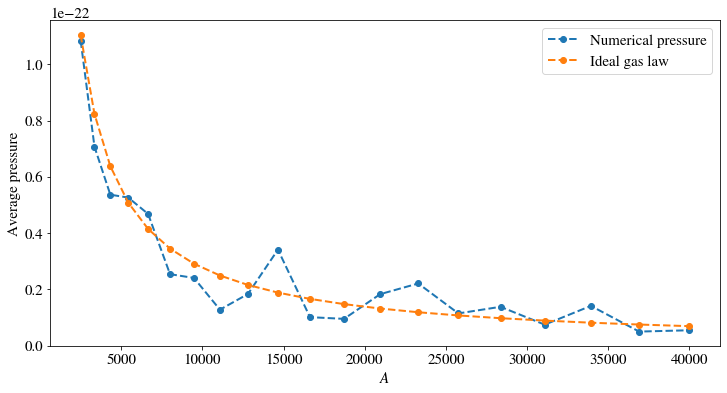

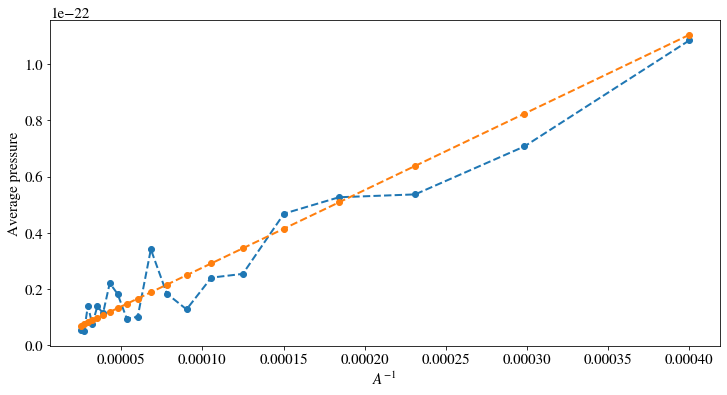

In [26]:
analytic_pressure_list = T*kB*N/(lengths**(2))
plt.plot(lengths**2, np.array(avg_pressure_list), "--o", label="Numerical pressure")
plt.plot(lengths**2, analytic_pressure_list, "--o", label="Ideal gas law")
plt.xlabel(r"$A$")
# plt.ylim(0, 3e-21)
plt.ylabel("Average pressure")
plt.legend()
plt.show()

plt.plot(lengths**(-2), np.array(avg_pressure_list), "--o", label="Numerical pressure")
plt.plot(lengths**(-2), analytic_pressure_list, "--o",  label="Ideal gas law")
plt.xlabel(r"$A^{-1}$")
plt.ylabel("Average pressure")
plt.show()

The plots above shows the pressure plotted along with the area, and the inverse of the area. The plots seem to indicate that there is an inverse relationship between the pressure and the area, as expected from the ideal gas law. We can also see that the ideal gas gives an almost identical result.

## Task b)

In [26]:
lengths = np.linspace(15, 30, 20)
N = 200
kB = 1.38e-23
beta = (kB * 300)**(-1)
steps = int(1e5)
a = 1
b = 0.5
U = 10000/beta
K = 200/beta

print("^"*len(lengths))
avg_pressure_list = []
for L in lengths:
    particle_list = np.zeros((N, 2))
    for i in range(N):
        particle_list[i] = np.array([np.random.random()*L, np.random.random()*L])
    print("*", end="")
    states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), lambda p1, p2 : hardcore_repulsion_potential_function(p1, p2, a, U), steps, beta, b)
    pressure_list = np.array([calculate_pressure_function_numpy(states[i], K, L) for i in range(0, states.shape[0], 100)])
    avg_pressure = np.average(pressure_list)
    avg_pressure_list.append(avg_pressure)



^^^^^^^^^^^^^^^^^^^^
********************

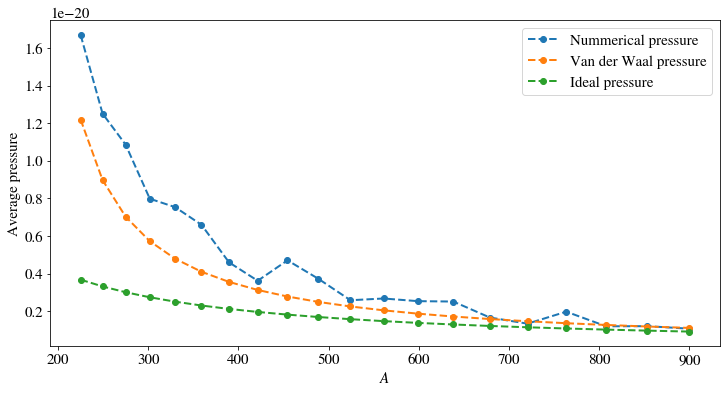

In [27]:
analytic_pressure_list = 300*kB*N/(lengths**(2) - np.pi*(a/2)**2 *N) 
# + (N/lengths**2)**2
ideal_pressure_list = 300*kB*N/(lengths**(2))

plt.plot(lengths**2, np.array(avg_pressure_list), "--o", label="Nummerical pressure")
plt.plot(lengths**2, analytic_pressure_list, "o--", label="Van der Waal pressure")
plt.plot(lengths**2, ideal_pressure_list, "o--", label="Ideal pressure")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel("Average pressure")
plt.show()

The nummerically calculated pressure seems to correspond with the Van der Waals equation, and not with the ideal case.

## Task c)

In [28]:
lengths = np.linspace(50, 200, 20)
N = 200
kB = 1.38e-23
beta =(2)**(-1)
steps = int(1e5)
a = 1
b= 0.5
epsilon = 1
K = 200/beta

# states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), lambda p1, p2 : 0, steps, beta, b)

print("^"*len(lengths))
avg_pressure_list = []
for L in lengths:
    particle_list = np.zeros((N, 2))
    for i in range(N):
        particle_list[i] = np.array([np.random.random()*L, np.random.random()*L])
    states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), lambda p1, p2 : lennard_jones_potential_function(p1, p2, a, epsilon), steps, beta, b)
    print("*", end="")
    pressure_list = np.array([calculate_pressure_function_numpy(states[i], K, L) for i in range(0, states.shape[0], 100)])
    avg_pressure = np.average(pressure_list)
    avg_pressure_list.append(avg_pressure)



^^^^^^^^^^^^^^^^^^^^
********************

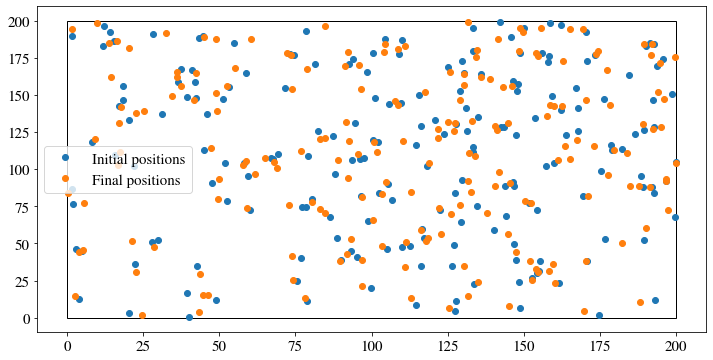

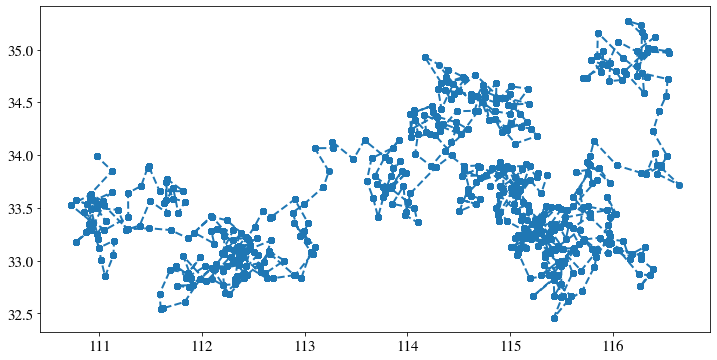

In [29]:
fig, ax = plt.subplots()
ax.plot(states[0, :, 0], states[0, :, 1], "o", label="Initial positions")
ax.plot(states[-1, :, 0], states[-1, :, 1], "o", label="Final positions")
rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
ax.add_patch(rect)
ax.legend()
plt.show()

j = np.random.randint(0, states.shape[1])
p1_x_values = states[:, j, 0] 
p1_y_values = states[:, j, 1] 
plt.plot(p1_x_values, p1_y_values, "--o")
plt.show()

The first plot above shows the initial and final positions in of gas particles when using the Lennard-Jones potential and the wall repulsion potential. The second plot shows the path of a random particle during the simulation. Notice that the particles has a decent amount of movement during the simulation.

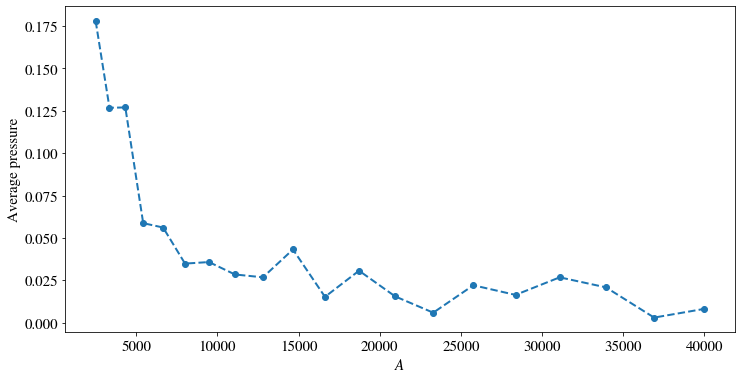

In [30]:
plt.plot(lengths**2, np.array(avg_pressure_list), "--o")
plt.xlabel(r"$A$")
plt.ylabel("Average pressure")
plt.show()

The plot above shows the average pressure as a function of area for the Lennard-Jones potential and wall repulsion potential of a gas.

## Task d)

In [34]:
kBT_list = np.linspace(0.1, 5, 20)
N = 200
steps = int(1e5)
a = 1
b= 0.5
epsilon = 1
kB = 1.38e-23
K = 200
L = 50

particle_list = np.zeros((N, 2))
for i in range(N):
    particle_list[i] = np.array([np.random.random()*L, np.random.random()*L])

print("^"*len(kBT_list))
avg_pressure_list = []
for kT in kBT_list:
    beta = 1/kT
    states = MonteCarlo_metropolis2D_numpy(particle_list, lambda p : wall_potential_function_numpy(p, K, L), lambda p1, p2 : lennard_jones_potential_function(p1, p2, a, epsilon), steps, beta, b)
    print("*", end="")
    pressure_list = np.array([calculate_pressure_function_numpy(states[i], K, L) for i in range(0, states.shape[0], 100)])
    avg_pressure = np.average(pressure_list)
    avg_pressure_list.append(avg_pressure)
    


^^^^^^^^^^^^^^^^^^^^
********************

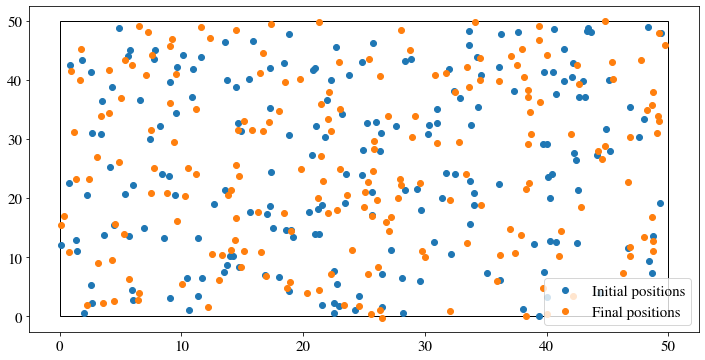

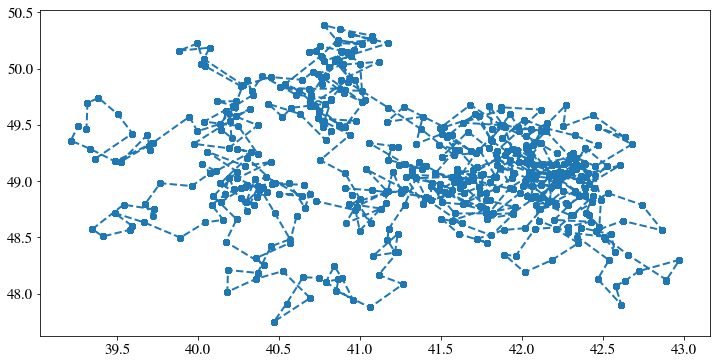

In [35]:
fig, ax = plt.subplots()
ax.plot(states[0, :, 0], states[0, :, 1], "o", label="Initial positions")
ax.plot(states[-1, :, 0], states[-1, :, 1], "o", label="Final positions")
rect = plt.Rectangle((0,0), L, L, linewidth=1, edgecolor="k", facecolor="none")
ax.add_patch(rect)
ax.legend()
plt.show()

j = np.random.randint(0, states.shape[1])
p1_x_values = states[:, j, 0] 
p1_y_values = states[:, j, 1] 
plt.plot(p1_x_values, p1_y_values, "--o")
plt.show()

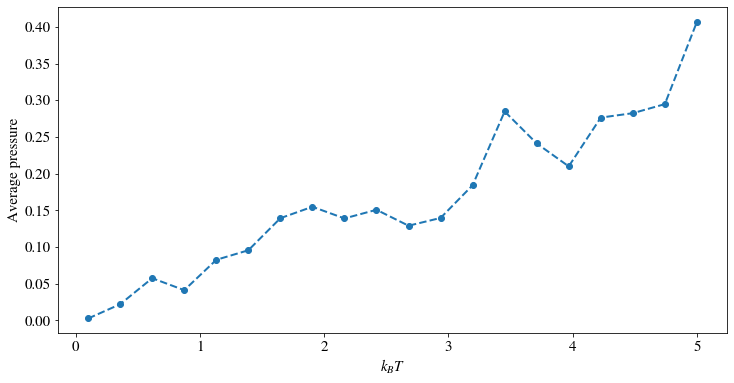

In [36]:
plt.plot(kBT_list, avg_pressure_list, "--o")
plt.xlabel(r"$k_{B}T$")
plt.ylabel("Average pressure")
plt.show()